In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [40]:
sns.set()
%matplotlib inline

In [41]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%autoreload 2

In [43]:
from sir_models.sir import SIROneStain

# Load data

In [44]:
df = pd.read_csv('data/data.csv', sep=';')

In [45]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [46]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [47]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


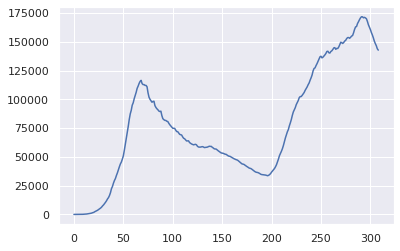

In [48]:
df['infected'].plot()

In [49]:
df_smoothed = df.drop(columns=['region']).rolling(3).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-13
2,122.000000,27.333333,0.000000,0.0,0.0,11.666667,0.000000,27.333333,2020-03-14
3,204.000000,32.000000,0.333333,0.0,0.0,4.666667,0.333333,31.666667,2020-03-15
4,286.000000,41.000000,0.666667,0.0,0.0,9.000000,0.333333,40.333333,2020-03-16
5,368.000000,47.666667,1.000000,0.0,0.0,6.666667,0.333333,46.666667,2020-03-17
6,450.666667,64.666667,1.000000,0.0,0.0,17.000000,0.000000,63.666667,2020-03-18
7,534.333333,79.666667,1.000000,0.0,0.0,15.000000,0.000000,78.666667,2020-03-19
8,619.000000,105.000000,2.333333,0.0,0.0,25.333333,1.333333,102.666667,2020-03-20
9,704.000000,122.000000,4.666667,0.0,0.0,17.000000,2.333333,117.333333,2020-03-21


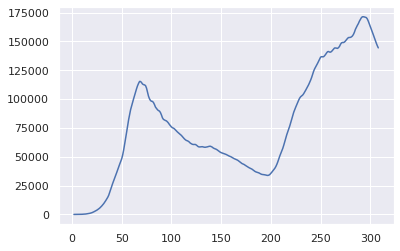

In [50]:
df_smoothed.infected.plot()

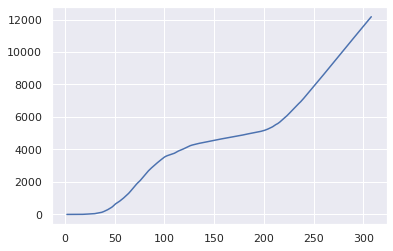

In [51]:
df_smoothed.total_dead.plot()

In [52]:
df = df_smoothed.dropna().reset_index(drop=True)

# Set global params

In [53]:
population = 12_000_000
#population = 140_000_000

In [54]:
start_day = df.iloc[0].date
end_day = df.iloc[-1].date
days_in_cycle = 1
dates = pd.date_range(start=start_day,
                      end=end_day,
                      freq=f"{days_in_cycle}D")

t = np.arange(len(dates))
len(t)

307

# SIR first peak

In [56]:
model = SIROneStain(population)

subset = df[20:110]
model.fit(subset)

result = model.fit_result_
#result.plot_fit(datafmt="-");
result

In [57]:
R0 = result.params['beta']/result.params['gamma']
R0

1.273984564725779

In [58]:
S, I, R, D = model.predict_train()

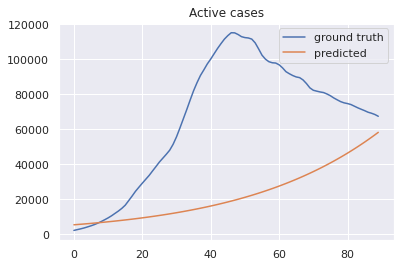

In [59]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

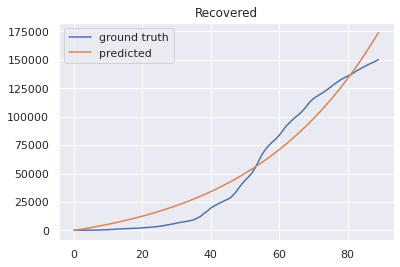

In [60]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

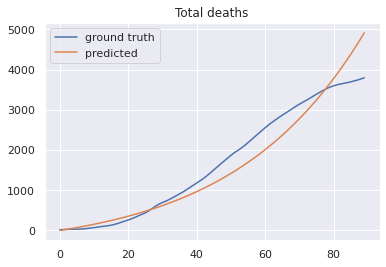

In [61]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

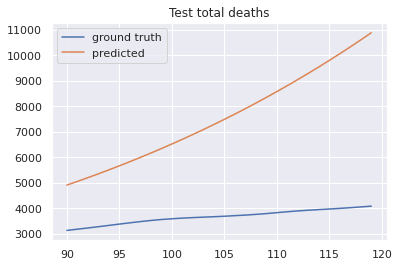

In [62]:
test_subset = df[len(subset):len(subset)+30]

test_t = np.arange(len(subset), len(subset)+len(test_subset))
S, I, R, D = model.predict_test(test_t)

plt.figure()
plt.plot(test_t, test_subset['total_dead'], label='ground truth')
plt.plot(test_t, D, label='predicted')
plt.legend()
plt.title('Test total deaths')
plt.show()

# SIR recent

In [67]:
model = SIROneStain(population)

subset = df[150:]
model.fit(subset)

S, I, R, D = model.predict_train()
result = model.fit_result_
result

In [68]:
R0 = result.params['beta']/result.params['gamma']
R0

0.9861095787921759

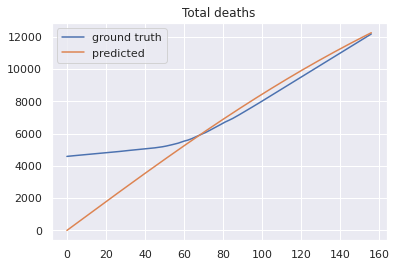

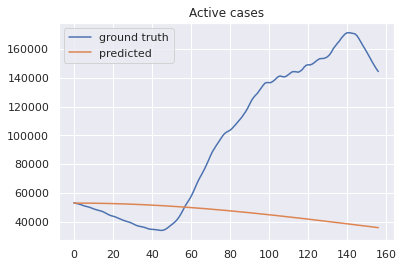

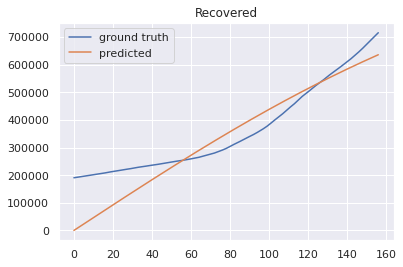

In [69]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

# SIR full

In [73]:
model = SIROneStain(population)
subset = df
model.fit(subset)

S, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

1.079454231334042

In [74]:
result

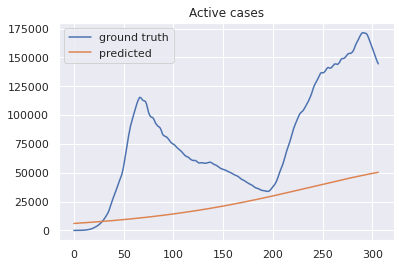

In [75]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

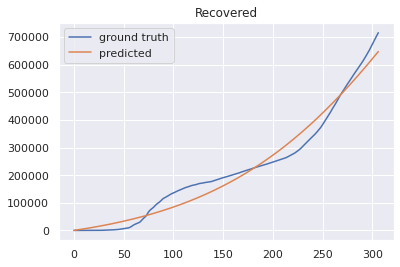

In [76]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

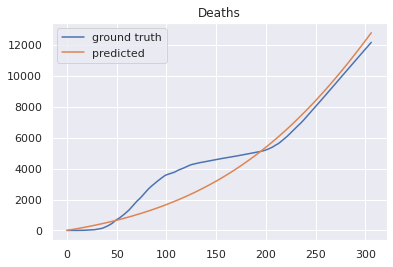

In [77]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Deaths')
plt.show()

# Evaluate predictive ability

In [78]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

In [79]:
tscv = TimeSeriesSplit(n_splits=10)

Fold 0
37 27


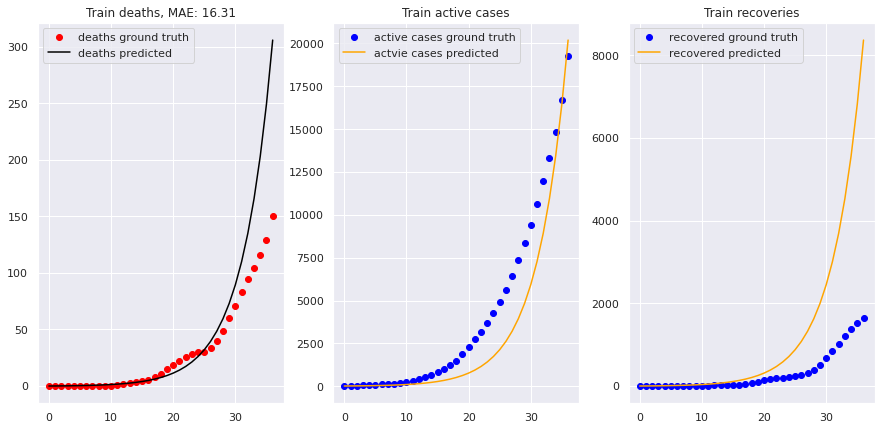

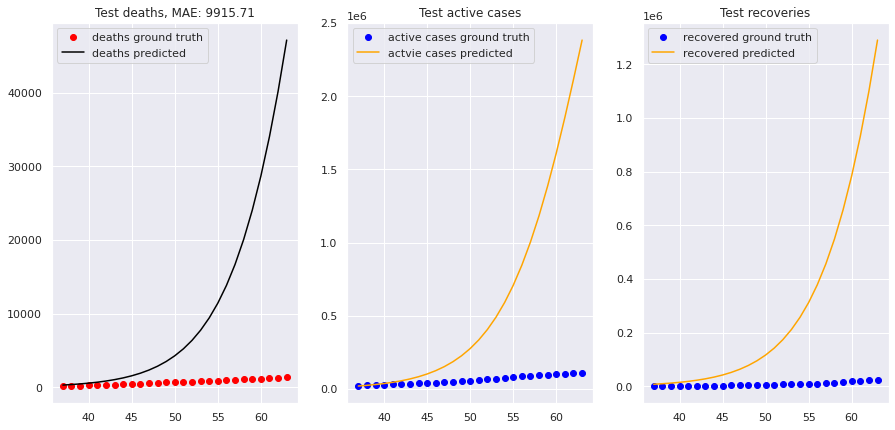

Test R^2: -2038.619470540624
Fold 1
64 27


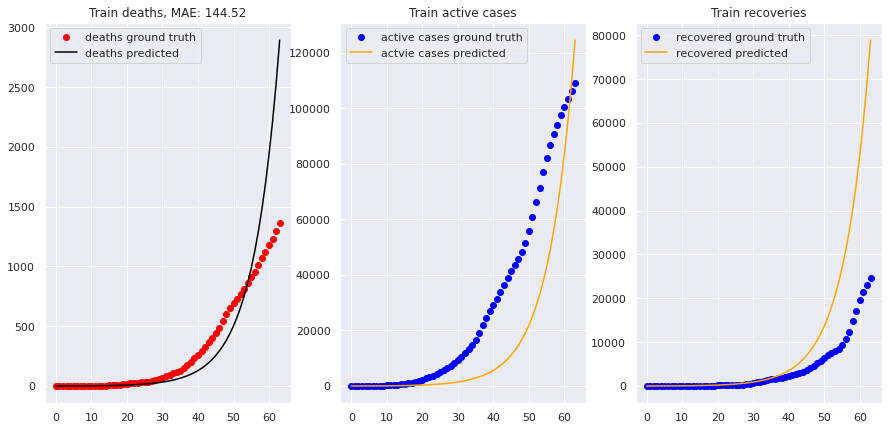

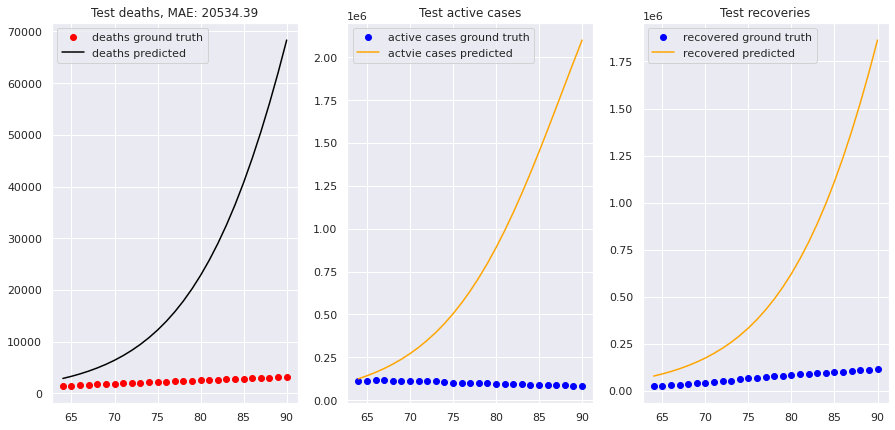

Test R^2: -2888.1593648852163
Fold 2
91 27


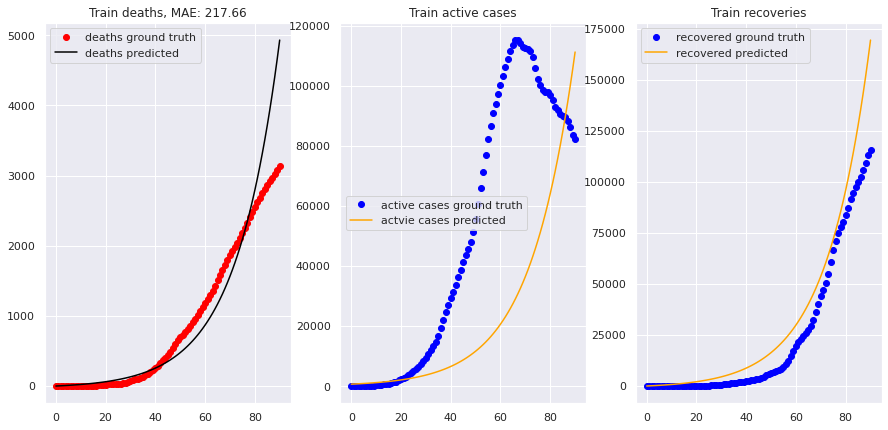

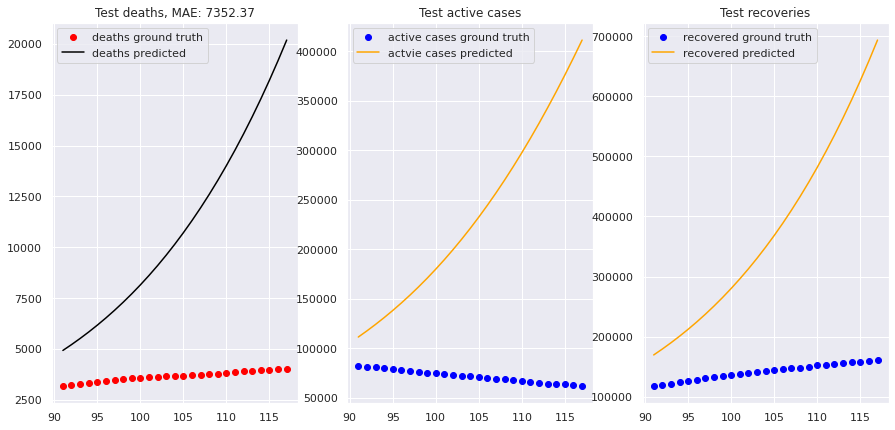

Test R^2: -1282.5072573213088
Fold 3
118 27


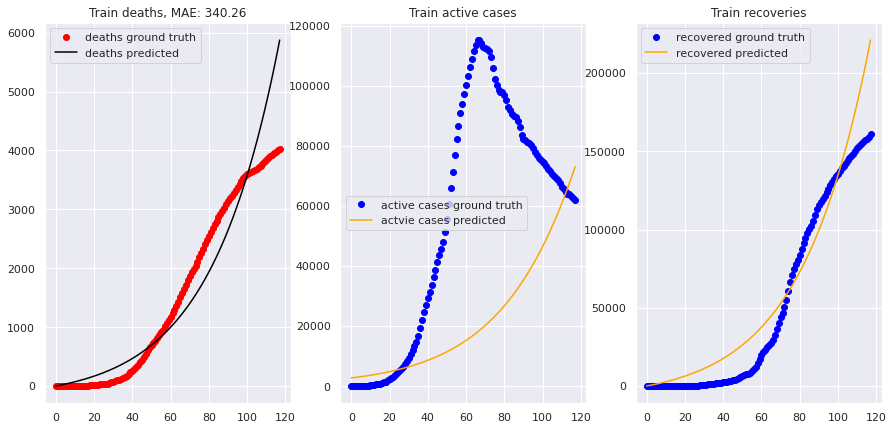

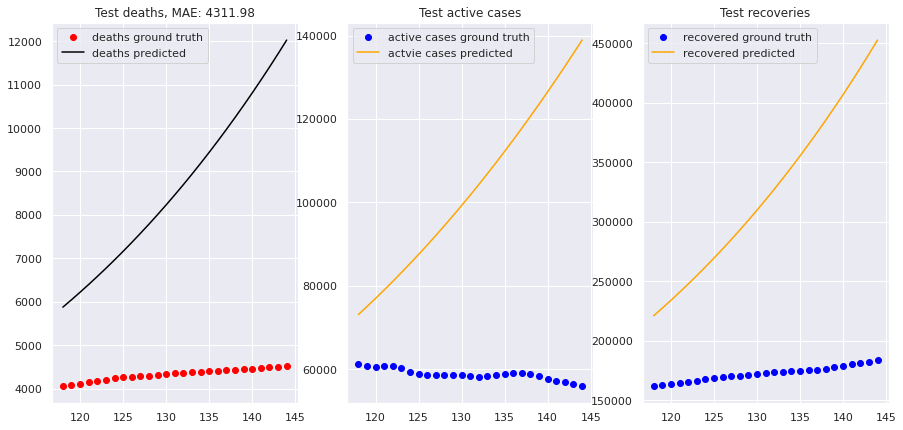

Test R^2: -1293.0606409944505
Fold 4
145 27


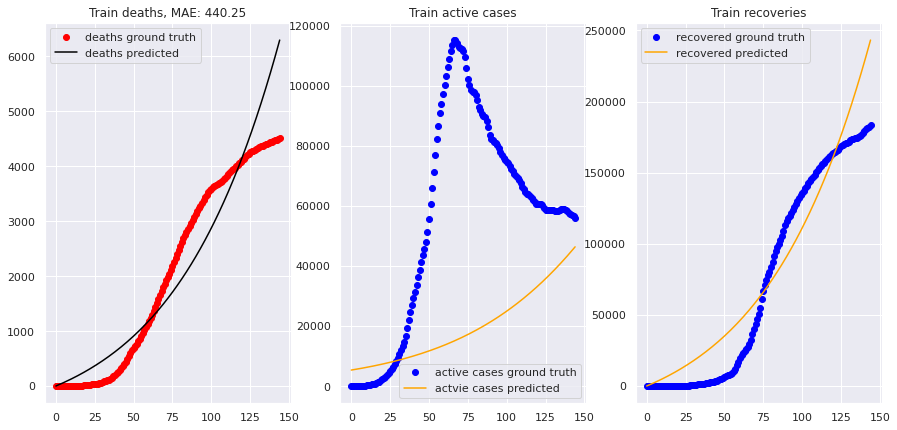

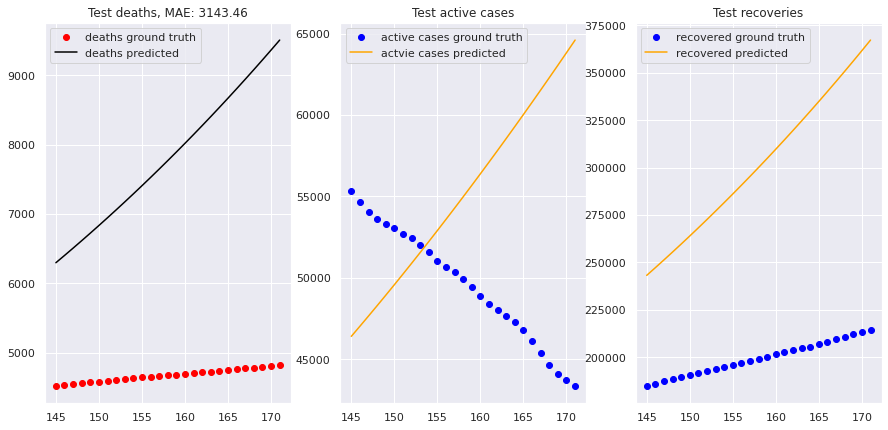

Test R^2: -1366.3229492845
Fold 5
172 27


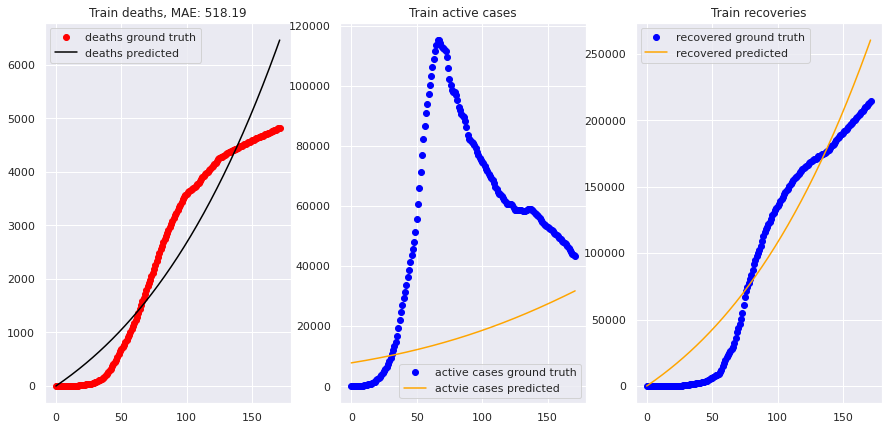

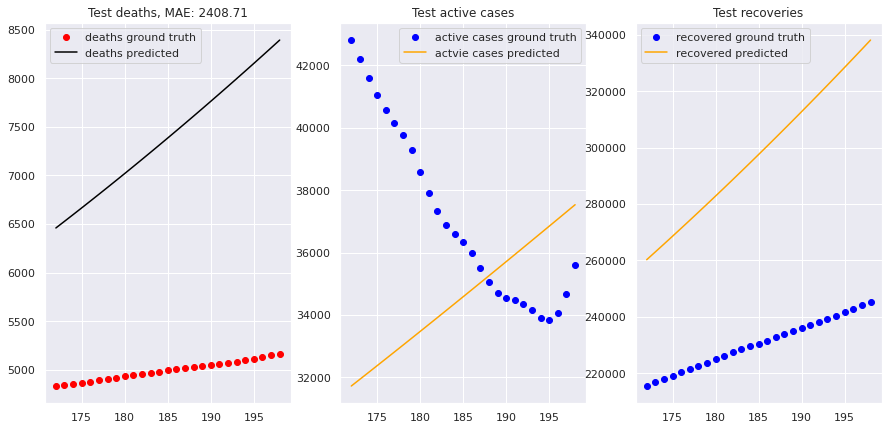

Test R^2: -654.9517377719657
Fold 6
199 27


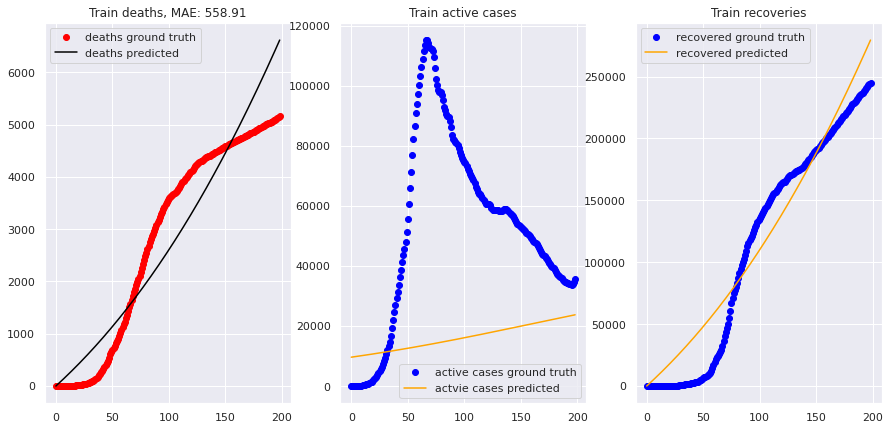

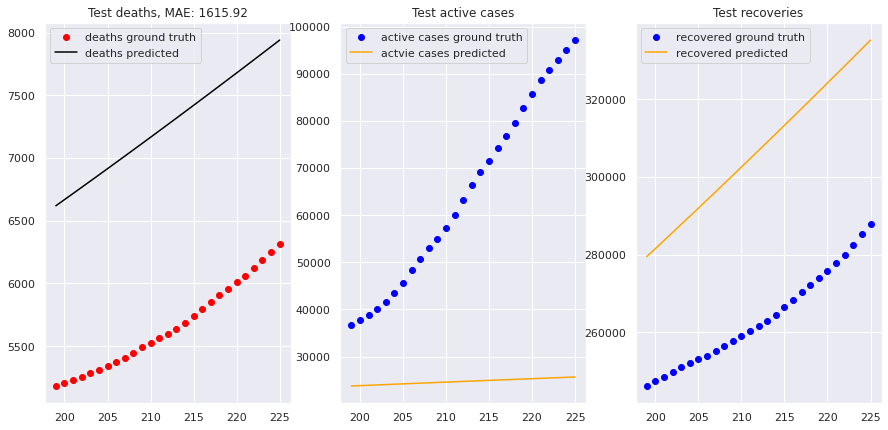

Test R^2: -21.346877369071972
Fold 7
226 27


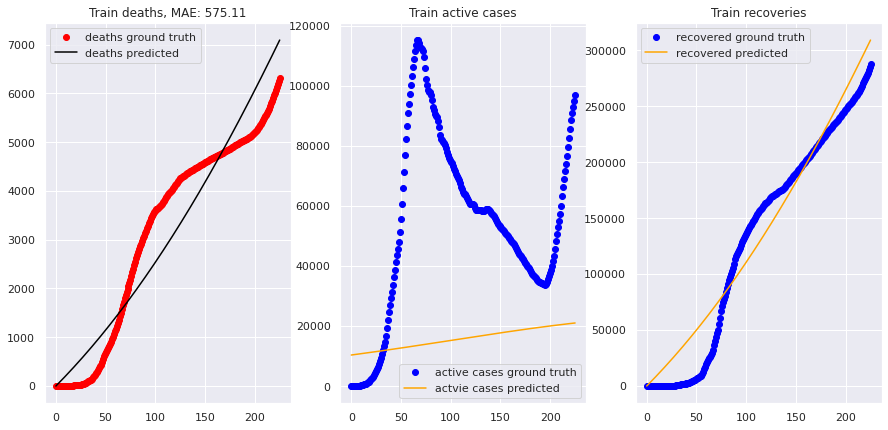

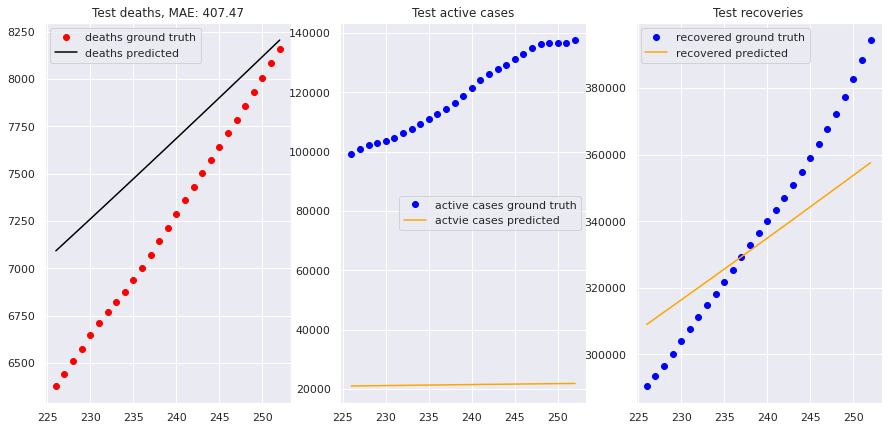

Test R^2: 0.27363405085164816
Fold 8
253 27


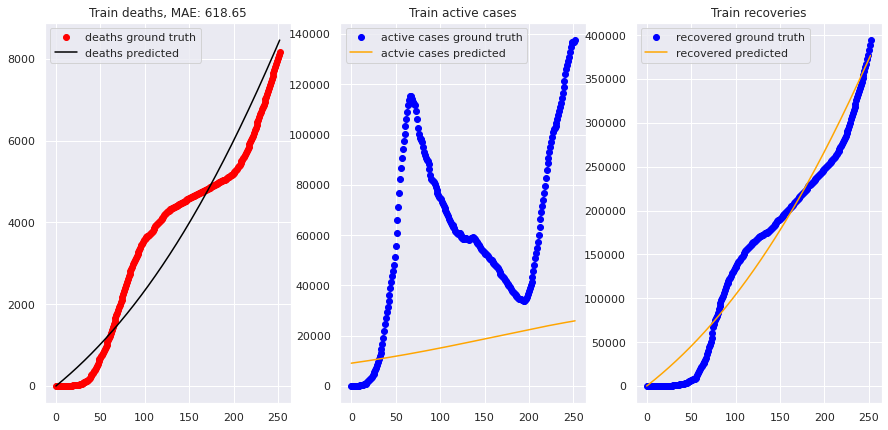

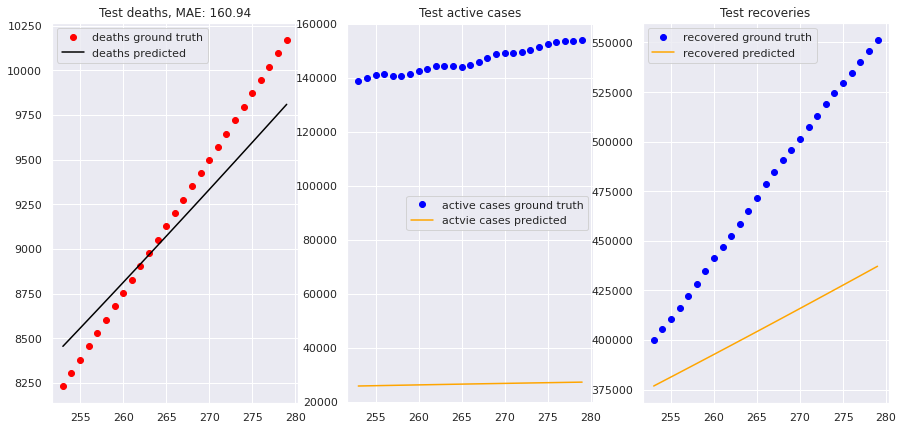

Test R^2: 0.89343872355825
Fold 9
280 27


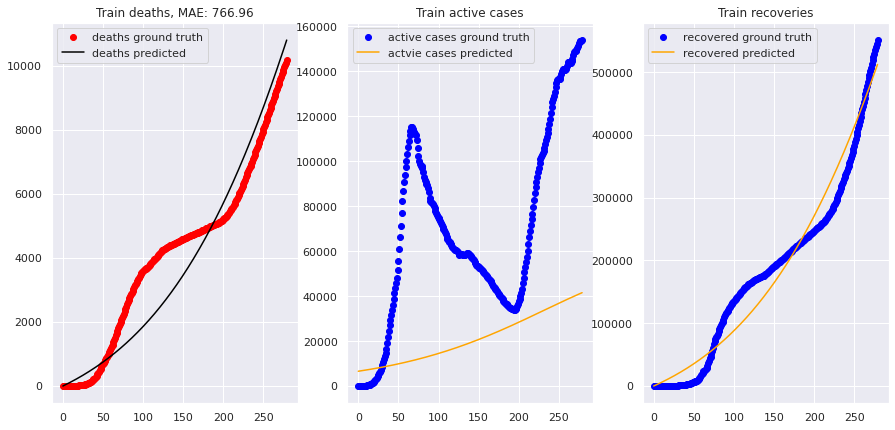

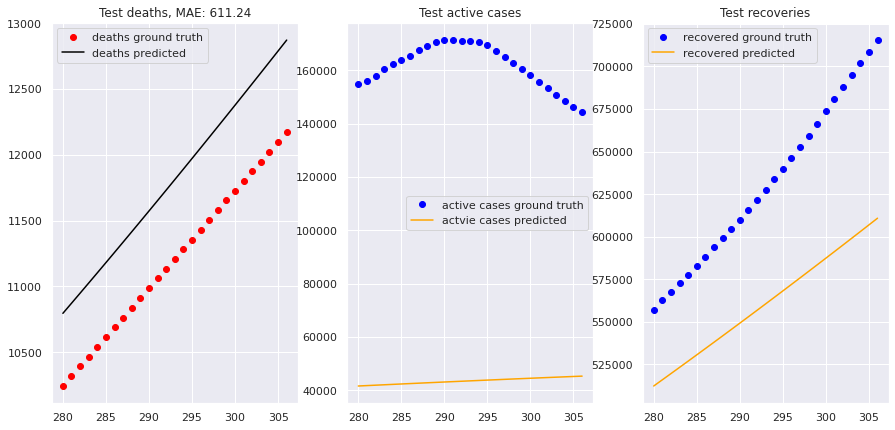

Test R^2: -0.12734035359810125


In [81]:
maes = []
params = []
for i, (train_index, test_index) in enumerate(tscv.split(range(len(df)))):
    print('Fold', i)
    print(len(train_index), len(test_index))
    train_subset = df.iloc[train_index]
    test_subset = df.iloc[test_index]
    
    model = SIROneStain(population)
    model.fit(train_subset)

    result = model.fit_result_
    params.append(result.params)
    #result.plot_fit(datafmt="-")
    
    train_S, train_I, train_R, train_D = model.predict_train()
    S, I, R, D = model.predict_test(test_index)
    
    train_mae = mean_absolute_error(train_subset['total_dead'], train_D)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(train_index, train_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(train_index, train_D, label='deaths predicted', color='black')
    plt.title(f'Train deaths, MAE: {train_mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(train_index, train_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(train_index, train_I, label='actvie cases predicted', color='orange')
    plt.title(f'Train active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(train_index, train_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(train_index, train_R, label='recovered predicted', color='orange')
    plt.title(f'Train recoveries')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(test_subset['total_dead'], D)
    maes.append(mae)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(test_index, test_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(test_index, D, label='deaths predicted', color='black')
    plt.title(f'Test deaths, MAE: {mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(test_index, test_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(test_index, I, label='actvie cases predicted', color='orange')
    plt.title(f'Test active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(test_index, test_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(test_index, R, label='recovered predicted', color='orange')
    plt.title(f'Test recoveries')
    plt.legend()
    plt.show()
    
    print('Test R^2:', r2_score(test_subset['total_dead'], D))

In [82]:
params[-1]

name,value,standard error,relative error,initial value,min,max,vary
population,12000000.0,0.00000000,(0.00%),12000000,-inf,inf,False
beta,0.09735653,5.0911e-04,(0.52%),1.2,0.00000000,10.0000000,True
gamma,0.09090909,0.00000000,(0.00%),0.09090909090909091,0.00000000,1.00000000,False
alpha,0.04043846,0.00125216,(3.10%),0.018,0.00000000,0.20000000,True
rho,0.04545455,0.00000000,(0.00%),0.045454545454545456,0.00000000,0.08333333,False
i0,6593.45750,305.546651,(4.63%),1000,0.00000000,12000000.0,True


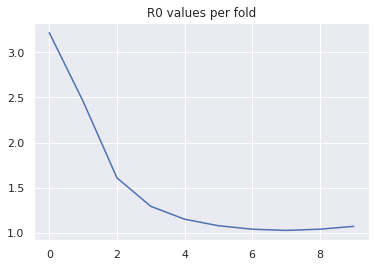

In [83]:
betas = [p['beta'] for p in params]
gamma = params[0]['gamma']
r0s = [b/gamma for b in betas]
r0s

plt.plot(r0s)
plt.title('R0 values per fold')
plt.show()

In [84]:
r0s[-1]

1.0709217801176067

In [85]:
np.mean(maes)

5046.21864452347